In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#!python -m wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

100% [......................................................] 1423529 / 1423529
Saved under housing (5).csv


In [2]:
df = pd.read_csv('housing (5).csv')

In [3]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
len(list(df.columns))

10

In [5]:
df.fillna(0,inplace=True)

In [6]:
df['median_house_value'] = np.log1p(df['median_house_value'])

In [7]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,13.022766,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,12.789687,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,12.771673,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,12.740520,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,12.743154,NEAR BAY


In [8]:
from sklearn.model_selection import train_test_split

In [9]:
df_full_train,df_test = train_test_split(df,test_size=0.2,random_state=1)
df_train,df_val = train_test_split(df_full_train,test_size=0.25,random_state=1)

In [10]:
y_train = df_train['median_house_value'].values
y_val = df_val['median_house_value'].values
y_test = df_test['median_house_value'].values


In [11]:
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [12]:
from sklearn.feature_extraction import DictVectorizer

In [13]:
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

In [14]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

In [15]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [16]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



/home/akram/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [20]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [21]:
y_pred = rf.predict(X_val)
np.sqrt(mean_squared_error(y_val, y_pred))

0.24566012875324927

In [22]:
scores=[]
for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    
    scores.append((n, score))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

Text(0, 0.5, 'RMSE')

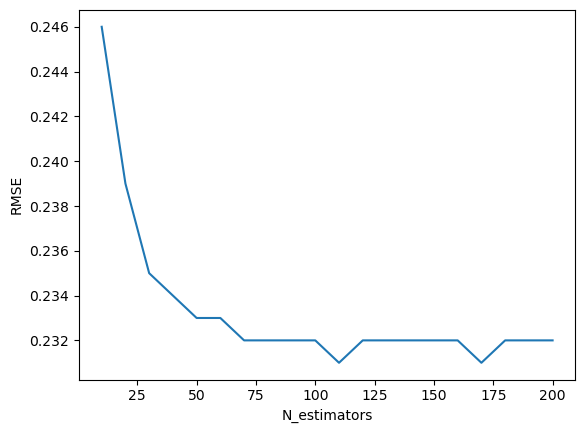

In [23]:
plt.plot(df_scores.n_estimators, df_scores.rmse.round(3))
plt.xlabel('N_estimators')
plt.ylabel('RMSE')

In [24]:
scores_max=[]
max_depth = [10, 15, 20, 25]
for i in max_depth:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(max_depth=i,n_estimators=n, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_pred))

        scores_max.append((i, n, score))

df_scores_max = pd.DataFrame(scores_max, columns=['max_depth','n_estimators', 'rmse'])

Text(0, 0.5, 'RMSE')

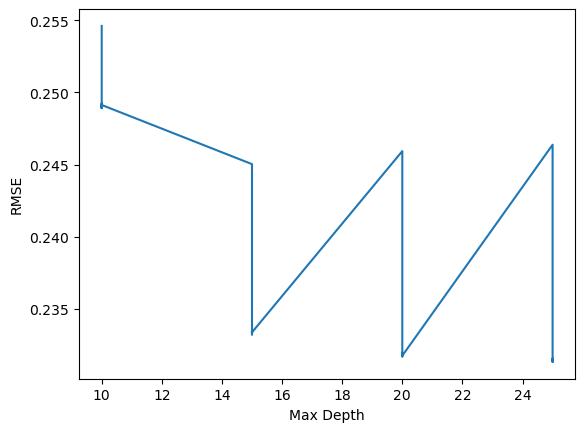

In [26]:
plt.plot(df_scores_max.max_depth,df_scores_max.rmse)
plt.xlabel('Max Depth')
plt.ylabel('RMSE')

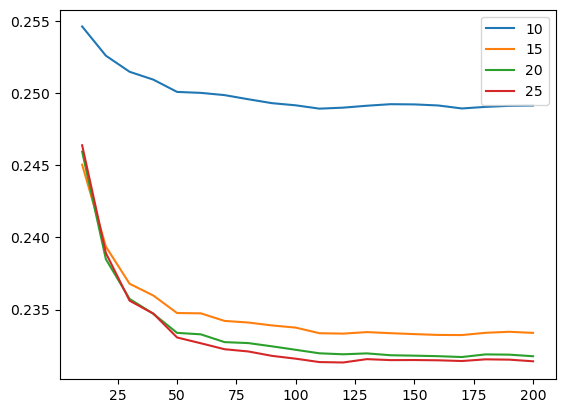

In [27]:
for m in [10, 15, 20, 25]:
    df_subset = df_scores_max[df_scores_max.max_depth == m]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label=m)

plt.legend()


In [28]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, 
                           random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [29]:
rf.feature_importances_

array([1.63873827e-02, 3.31454580e-02, 1.01255849e-01, 9.64702137e-02,
       3.63325843e-01, 2.48880276e-03, 3.10900842e-01, 3.56806263e-04,
       4.80369796e-04, 4.69876693e-03, 3.07769212e-02, 1.91716318e-02,
       2.05411131e-02])

In [30]:
df_importances = pd.DataFrame()
df_importances['feature'] = dv.get_feature_names()
df_importances['importance'] = rf.feature_importances_
df_importances

/home/akram/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,feature,importance
0,households,0.016387
1,housing_median_age,0.033145
2,latitude,0.101256
3,longitude,0.096470
4,median_income,0.363326
5,ocean_proximity=<1H OCEAN,0.002489
6,ocean_proximity=INLAND,0.310901
7,ocean_proximity=ISLAND,0.000357
8,ocean_proximity=NEAR BAY,0.000480
9,ocean_proximity=NEAR OCEAN,0.004699


In [31]:
df_importances.sort_values(by='importance', ascending=False).head()

,feature,importance
4,median_income,0.363326
6,ocean_proximity=INLAND,0.310901
2,latitude,0.101256
3,longitude,0.096470
1,housing_median_age,0.033145


In [32]:
import xgboost as xgb

In [64]:
features = dv.feature_names_

In [66]:
regex = re.compile(r"<", re.IGNORECASE)
features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]

In [68]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [69]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [70]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [71]:
xgb_scores = {}

In [72]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [73]:
xgb_scores['eta=0.3'] = parse_xgb_output(output)

In [74]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [75]:
xgb_scores['eta=0.1'] = parse_xgb_output(output)

(0.0, 100.0)

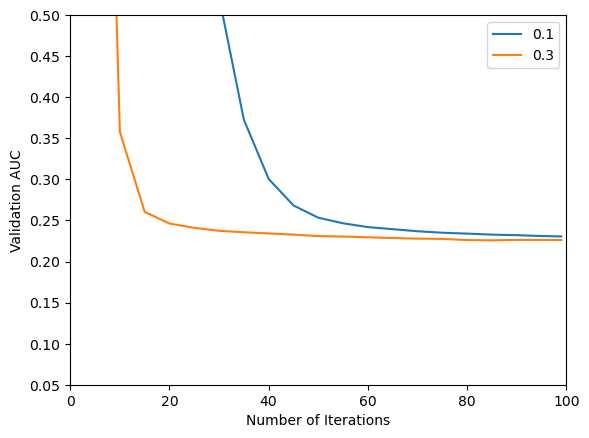

In [80]:
plt.plot(xgb_scores['eta=0.1'].num_iter, xgb_scores['eta=0.1'].val_auc,
        label='0.1')
plt.plot(xgb_scores['eta=0.3'].num_iter, xgb_scores['eta=0.3'].val_auc,
        label='0.3')
plt.legend()
plt.xlabel('Number of Iterations')
plt.ylabel('Validation AUC')
plt.ylim([0.05, 0.5])
plt.xlim([0, 100])